In [16]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [17]:
if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL

## Models


In [18]:
print(config.channels)

class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)
    



class ResNet101_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_Classifier, self).__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        # Modify the input layer to match your input data channels
        # If your input data has different channels, adjust this line accordingly
        self.resnet101.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet101.fc.in_features
        self.resnet101.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet101(x)
    

    
class ModifiedResnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResnet50_Classifier, self).__init__()
        
        # Load the pretrained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Modify the first convolutional layer
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet50.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3


In [19]:
#------Datasplit
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
train_df, temp = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
test_df, val_df = train_test_split(temp, test_size=0.5, stratify=temp['Label_int'], random_state=47)
# train test split
print("Train size: ", len(train_df))
print("Test size: ", len(test_df))
print("Val size: ", len(val_df))






Train size:  3776
Test size:  472
Val size:  472


In [20]:
print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64


In [21]:
train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)

#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  # Assuming the number of classes is the unique count of "Label_int" in your labels_file
#model = Resnet50_Classifier(num_classes)
model = ModifiedResnet50_Classifier(num_classes)
#model = ResNet101_Classifier(num_classes)



#  Transfer the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay = 1e-4 ) # Adjust the value as needed)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

train_losses = []
test_losses = []
config.best_accuracy = 0
config.model_path = "./results_standalone/test2_27_10_checkpoint.pth"
# Training loop
num_epochs = 50  # Adjust this as needed
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    correct_predictions = 0
    total_samples = 0

    # Set the model to evaluation mode (important for dropout and batch normalization)
    model.eval()

    # Iterate through the test set
    with torch.no_grad():  # Disable gradient computation during testing
        for spectrograms, labels in test_loader:
            # Move data to the testing device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            
            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update evaluation metrics
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    #if new test accuracy is better than the previous best, save the model
    if correct_predictions / total_samples > config.best_accuracy:
        config.best_accuracy = correct_predictions / total_samples
        torch.save(model, config.model_path)
        
    # Step the learning rate scheduler
    scheduler.step(test_losses[-1])

    # Calculate accuracy or other evaluation metrics
    accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f} and Test Loss: {test_losses[-1]:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

torch.save(model, "./results_standalone/test2FULL_27_10_checkpoint.pth")

c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 118/118 [00:52<00:00,  2.27it/s]


Epoch [1/50], Train Loss: 0.4930 and Test Loss: 0.7227
Test Accuracy: 77.33%


100%|██████████| 118/118 [00:51<00:00,  2.28it/s]


Epoch [2/50], Train Loss: 0.4722 and Test Loss: 0.5390
Test Accuracy: 78.81%


100%|██████████| 118/118 [00:51<00:00,  2.28it/s]


Epoch [3/50], Train Loss: 0.4678 and Test Loss: 0.6970
Test Accuracy: 84.53%


100%|██████████| 118/118 [00:50<00:00,  2.33it/s]


Epoch [4/50], Train Loss: 0.3539 and Test Loss: 0.2222
Test Accuracy: 84.75%


100%|██████████| 118/118 [00:51<00:00,  2.27it/s]


Epoch [5/50], Train Loss: 0.3836 and Test Loss: 0.3849
Test Accuracy: 81.78%


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Epoch [6/50], Train Loss: 0.2563 and Test Loss: 0.4668
Test Accuracy: 84.32%


100%|██████████| 118/118 [00:54<00:00,  2.18it/s]


Epoch [7/50], Train Loss: 0.4163 and Test Loss: 0.1893
Test Accuracy: 84.11%


100%|██████████| 118/118 [00:51<00:00,  2.27it/s]


Epoch [8/50], Train Loss: 0.3533 and Test Loss: 0.2584
Test Accuracy: 86.44%


100%|██████████| 118/118 [00:50<00:00,  2.34it/s]


Epoch [9/50], Train Loss: 0.3008 and Test Loss: 0.8063
Test Accuracy: 86.02%


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Epoch [10/50], Train Loss: 0.5986 and Test Loss: 0.4235
Test Accuracy: 87.92%


100%|██████████| 118/118 [00:52<00:00,  2.26it/s]


Epoch [11/50], Train Loss: 0.3841 and Test Loss: 0.2686
Test Accuracy: 82.84%


100%|██████████| 118/118 [00:54<00:00,  2.18it/s]


Epoch [12/50], Train Loss: 0.1832 and Test Loss: 0.2591
Test Accuracy: 87.08%


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Epoch 00013: reducing learning rate of group 0 to 2.0000e-04.
Epoch [13/50], Train Loss: 0.1758 and Test Loss: 0.2124
Test Accuracy: 86.02%


100%|██████████| 118/118 [00:51<00:00,  2.27it/s]


Epoch [14/50], Train Loss: 0.4010 and Test Loss: 0.5993
Test Accuracy: 85.38%


100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


Epoch [15/50], Train Loss: 0.2922 and Test Loss: 0.4191
Test Accuracy: 87.92%


100%|██████████| 118/118 [00:51<00:00,  2.31it/s]


Epoch [16/50], Train Loss: 0.3629 and Test Loss: 0.1527
Test Accuracy: 88.56%


100%|██████████| 118/118 [00:52<00:00,  2.26it/s]


Epoch [17/50], Train Loss: 0.4299 and Test Loss: 0.2674
Test Accuracy: 88.77%


100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


Epoch [18/50], Train Loss: 0.1457 and Test Loss: 0.3033
Test Accuracy: 86.23%


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Epoch [19/50], Train Loss: 0.2755 and Test Loss: 0.2470
Test Accuracy: 86.65%


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Epoch [20/50], Train Loss: 0.1967 and Test Loss: 0.5494
Test Accuracy: 87.29%


100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


Epoch [21/50], Train Loss: 0.3165 and Test Loss: 0.1853
Test Accuracy: 88.77%


100%|██████████| 118/118 [00:50<00:00,  2.36it/s]


Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.
Epoch [22/50], Train Loss: 0.3646 and Test Loss: 0.3287
Test Accuracy: 86.86%


100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


Epoch [23/50], Train Loss: 0.2602 and Test Loss: 0.1628
Test Accuracy: 88.77%


100%|██████████| 118/118 [00:51<00:00,  2.28it/s]


Epoch [24/50], Train Loss: 0.2375 and Test Loss: 0.2383
Test Accuracy: 86.65%


100%|██████████| 118/118 [00:52<00:00,  2.27it/s]


Epoch [25/50], Train Loss: 0.6863 and Test Loss: 0.1793
Test Accuracy: 88.77%


100%|██████████| 118/118 [00:51<00:00,  2.27it/s]


Epoch [26/50], Train Loss: 0.2044 and Test Loss: 0.2441
Test Accuracy: 88.14%


100%|██████████| 118/118 [00:51<00:00,  2.31it/s]


Epoch [27/50], Train Loss: 0.1631 and Test Loss: 0.3227
Test Accuracy: 89.19%


100%|██████████| 118/118 [00:52<00:00,  2.25it/s]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-05.
Epoch [28/50], Train Loss: 0.3774 and Test Loss: 0.2561
Test Accuracy: 87.29%


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Epoch [29/50], Train Loss: 0.0666 and Test Loss: 0.3508
Test Accuracy: 87.71%


100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


Epoch [30/50], Train Loss: 0.1592 and Test Loss: 0.1368
Test Accuracy: 87.92%


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Epoch [31/50], Train Loss: 0.3523 and Test Loss: 0.2393
Test Accuracy: 87.50%


100%|██████████| 118/118 [00:50<00:00,  2.34it/s]


Epoch [32/50], Train Loss: 0.0866 and Test Loss: 0.2344
Test Accuracy: 87.71%


100%|██████████| 118/118 [00:50<00:00,  2.35it/s]


Epoch [33/50], Train Loss: 0.4030 and Test Loss: 0.1605
Test Accuracy: 87.29%


100%|██████████| 118/118 [00:51<00:00,  2.31it/s]


Epoch [34/50], Train Loss: 0.2374 and Test Loss: 0.2360
Test Accuracy: 89.41%


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Epoch [35/50], Train Loss: 0.0701 and Test Loss: 0.2490
Test Accuracy: 88.14%


100%|██████████| 118/118 [00:53<00:00,  2.20it/s]


Epoch 00036: reducing learning rate of group 0 to 2.5000e-05.
Epoch [36/50], Train Loss: 0.0525 and Test Loss: 0.2147
Test Accuracy: 88.77%


100%|██████████| 118/118 [00:56<00:00,  2.10it/s]


Epoch [37/50], Train Loss: 0.2813 and Test Loss: 0.2892
Test Accuracy: 87.71%


100%|██████████| 118/118 [00:55<00:00,  2.12it/s]


Epoch [38/50], Train Loss: 0.2398 and Test Loss: 0.2112
Test Accuracy: 88.14%


100%|██████████| 118/118 [00:54<00:00,  2.18it/s]


Epoch [39/50], Train Loss: 0.0793 and Test Loss: 0.1966
Test Accuracy: 89.19%


100%|██████████| 118/118 [00:55<00:00,  2.14it/s]


Epoch [40/50], Train Loss: 0.1197 and Test Loss: 0.2105
Test Accuracy: 89.41%


100%|██████████| 118/118 [00:54<00:00,  2.16it/s]


Epoch [41/50], Train Loss: 0.3220 and Test Loss: 0.2685
Test Accuracy: 89.19%


100%|██████████| 118/118 [00:53<00:00,  2.20it/s]


Epoch 00042: reducing learning rate of group 0 to 1.2500e-05.
Epoch [42/50], Train Loss: 0.1604 and Test Loss: 0.1677
Test Accuracy: 87.50%


100%|██████████| 118/118 [00:53<00:00,  2.21it/s]


Epoch [43/50], Train Loss: 0.2307 and Test Loss: 0.1776
Test Accuracy: 88.98%


100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


Epoch [44/50], Train Loss: 0.1871 and Test Loss: 0.5200
Test Accuracy: 87.92%


100%|██████████| 118/118 [00:53<00:00,  2.21it/s]


Epoch [45/50], Train Loss: 0.1201 and Test Loss: 0.2807
Test Accuracy: 88.14%


100%|██████████| 118/118 [00:53<00:00,  2.22it/s]


Epoch [46/50], Train Loss: 0.1185 and Test Loss: 0.2514
Test Accuracy: 88.77%


100%|██████████| 118/118 [00:55<00:00,  2.13it/s]


Epoch [47/50], Train Loss: 0.0867 and Test Loss: 0.2977
Test Accuracy: 88.14%


100%|██████████| 118/118 [00:55<00:00,  2.13it/s]


Epoch [48/50], Train Loss: 0.0577 and Test Loss: 0.1069
Test Accuracy: 88.14%


100%|██████████| 118/118 [00:54<00:00,  2.16it/s]


Epoch [49/50], Train Loss: 0.1748 and Test Loss: 0.2035
Test Accuracy: 88.14%


100%|██████████| 118/118 [00:53<00:00,  2.22it/s]


Epoch [50/50], Train Loss: 0.2657 and Test Loss: 0.4388
Test Accuracy: 87.92%



Evaluation Results:
Balanced Accuracy: 89.10%
Test Accuracy: 93.43%

Evaluation Results:
Accuracy: 93.43%
Precision: 93.44%
Recall: 93.43%
F1-score: 93.41%
Kappa: 89.62%


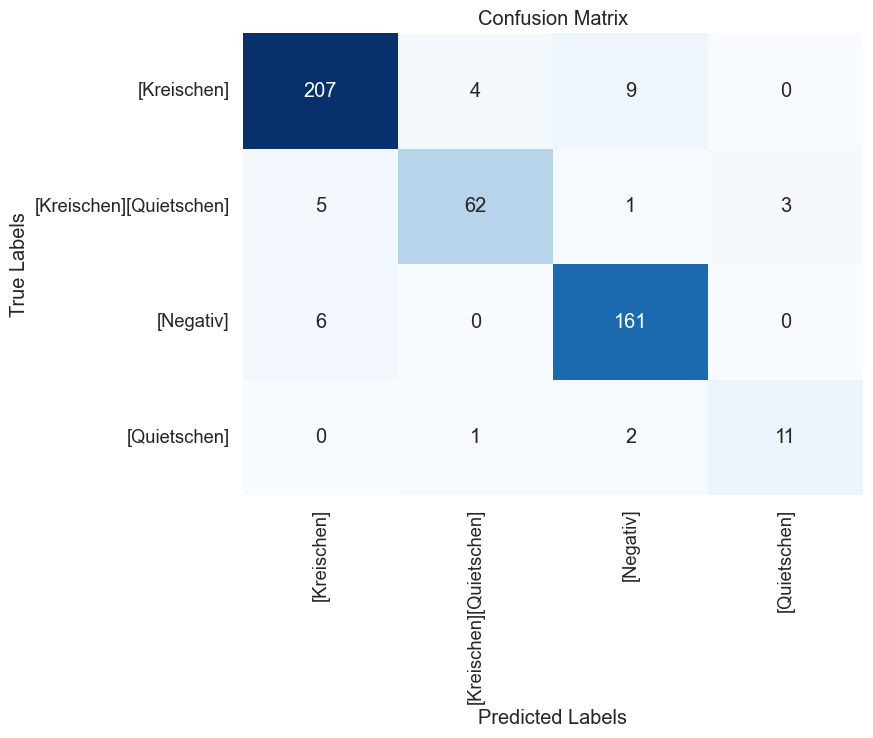

In [42]:
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import cohen_kappa_score
# Assuming you have already defined your model architecture
# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  # Assuming create_generators_finetune returns (train_loader, test_loader)


model = torch.load(config.model_path)
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode (important for dropout and batch normalization)
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')
_, recall_per_class, _, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels)


#calculate balanced accuracy
balanced_accuracy = np.mean(recall_per_class)

#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    # Convert class_labels to a list of strings (or integers)
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.show()

plot_confusion_matrix(conf_mat, true_labels_dic.values())

